In [1]:
import numpy as np
import igraph as ig
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
import scipy.stats as st
import pickle

sns.set()

In [2]:
with open('data/pickles/complete_df.pickle','rb') as f:
    df = pickle.load(f)

Costruisco per i primi 15 giorni una la rete aggiungengio un giorno alla volta, partendo da 3 giorni, e confronto la densità o la dimensone della componente connessa

In [3]:
df['day_count'].unique() #cotrollo quanti giorni di dati ho

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [4]:
def build_graph_by_day(data_retweet, fini_day,init_day = 0):
    sub_set = data_retweet[(data_retweet.day_count >= init_day)&(data_retweet.day_count < fini_day)]
    db_for_network = sub_set.groupby(['retweeted_status.user.id','user.id'], as_index=False).count()
    db_for_network = db_for_network[db_for_network.weight > 1]#.astype(int)
    return ig.Graph.TupleList(db_for_network[['retweeted_status.user.id','user.id','weight',]].itertuples(index=False), directed=True, weights=True)

In [71]:
def build_graph(data_retweet):
    db_for_network = data_retweet.groupby(['retweeted_status.user.id','user.id'], as_index=False).count()
    db_for_network = db_for_network[db_for_network.weight > 1]#.astype(int)
    return ig.Graph.TupleList(db_for_network[['retweeted_status.user.id','user.id','weight',]].itertuples(index=False), directed=True, weights=True)

In [5]:
#costruzione grafici della prima metà
graphs_first_15  = []
for day in range(3,16):
    graphs_first_15.append(build_graph_by_day(df, day)) 

da ognuno misuro la dimensione della più gande componente connessa

In [6]:
giant_connected_component_dimension = []
relative_gcc_dimension = []
for g in graphs_first_15:
    cl = g.components(mode='WEAK') #STRONG means that each pair of vertex must be reachable from each other
    giant_connected_component_dimension.append(len(cl.giant().vs)) # dimensione totale
    relative_gcc_dimension.append(len(cl.giant().vs)/len(g.vs))  # dimensione relativa

faccio lo stesso per gli ultimi 15 giorni

In [7]:
graphs_last_15  = []
for day in range(18,31):
    graphs_last_15.append(build_graph_by_day(df, day, init_day=15))
    
giant_connected_component_dimension_bis = []
relative_gcc_dimension_bis = []
for g in graphs_last_15:
    cl = g.components(mode='WEAK') 
    giant_connected_component_dimension_bis.append(len(cl.giant().vs))
    relative_gcc_dimension_bis.append(len(cl.giant().vs)/len(g.vs))

calcolo anche le densità

In [125]:
density_first = [g.density() for g in graphs_first_15]
density_last = [g.density() for g in graphs_last_15]

In [40]:
len(giant_connected_component_dimension)

13

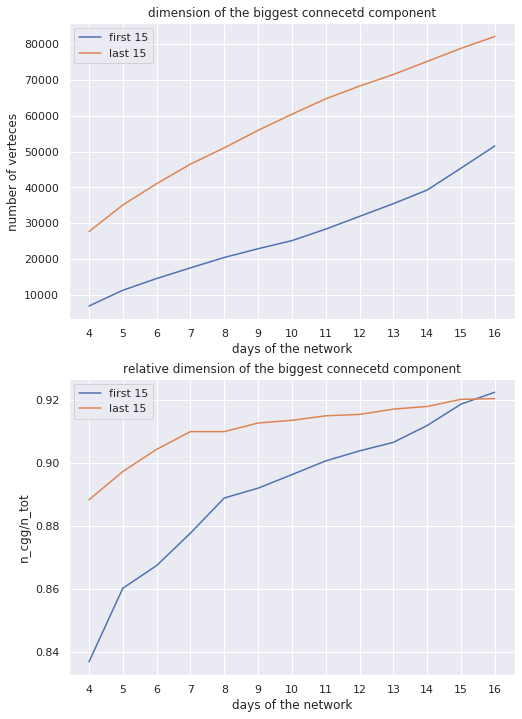

In [127]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (8,12))
ax1.plot(giant_connected_component_dimension, label='first 15')
ax1.plot(giant_connected_component_dimension_bis,label='last 15')
ax1.set_title('dimension of the biggest connecetd component')
ax1.set_ylabel('number of verteces')
ax1.set_xlabel('days of the network')
ax1.set_xticks(range(13))
ax1.set_xticklabels(range(4,17))
ax1.legend()
ax2.plot(relative_gcc_dimension,label='first 15')
ax2.plot(relative_gcc_dimension_bis, label='last 15')
ax2.set_title('relative dimension of the biggest connecetd component')
ax2.set_ylabel('n_cgg/n_tot')
ax2.set_xlabel('days of the network')
ax2.set_xticks(range(13))
ax2.set_xticklabels(range(4,17))
ax2.legend()
fig.savefig('size_change_gcc(days).png')

in entrambi i periodi la componente connessa tende a coprire tutto il network mano a mano che si aggiungono giorni, quindi nodi e link, al network. Nel secondo periodo appare comunque fin da subito più grande, sembra coprire tutto la maggiorparte del network in meno tempo.

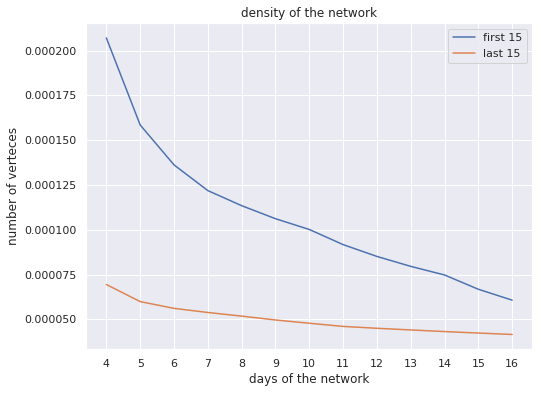

In [126]:
fig,ax = plt.subplots(1,1, figsize= (8,6))
ax.plot(density_first, label='first 15')
ax.plot(density_last, label = 'last 15')
ax.set_title('density of the network')
ax.set_ylabel('number of verteces')
ax.set_xlabel('days of the network')
ax.set_xticks(range(13))
ax.set_xticklabels(range(4,17))
fig.savefig('density(days).png')
ax.legend()

la densità tende a diminuire, poichè aumentano i nuovi nodi (quindi utenti che retweetano) e quindi aumentano i possibili collegamenti della rete ->  n*(n-1) / 2

Cosa accade se utilizzo il mode=STRONG per la ricerca della componente conessa, ovvero ogni coppia di utenti deve essere raggiungibile partendo da ciascuno dei due

In [97]:
gcc_strong = [[],[]]
rel_gcc_strong = [[],[]]
for g in graphs_first_15:
    cl = g.components(mode='STRONG') 
    gcc_strong[0].append(cl.giant().vcount())
    rel_gcc_strong[0].append(len(cl.giant().vs)/g.vcount())

for g in graphs_last_15:
    cl = g.components(mode='STRONG') 
    gcc_strong[1].append(len(cl.giant().vs))
    rel_gcc_strong[1].append(len(cl.giant().vs)/len(g.vs))

In [98]:
gcc_strong

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

Non sono presenti componenti di tal tipo

#### calcolo densità e dimensione della componente connessa 

In [38]:
g_tot = build_graph_by_day(df,31)

In [39]:
print('total density: ',g_tot.density())

total density:  3.720159610522477e-05


In [40]:
print('relative size of the gcc: ',g_tot.components(mode='WEAK').giant().vcount()/g_tot.vcount())  #relative size of the giant component

relative size of the gcc:  0.9341749473300045


guardo il numero dei nodi dei network del primo e secondo periodo

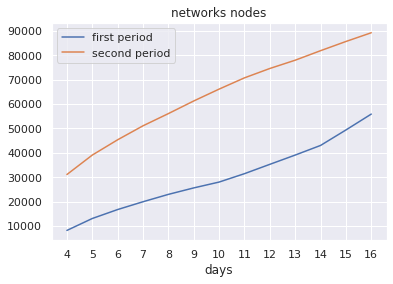

In [123]:
plt.title('networks nodes')
plt.plot([g.vcount() for g in graphs_first_15], label = 'first period')
plt.plot([g.vcount() for g in graphs_last_15], label = 'second period')
plt.xticks(range(13),range(4,17))
plt.legend()
plt.xlabel('days')
plt.savefig('network_nodes(days).png')
plt.show()

osservo che nel secondo priodo parto gia da un network con più di 3 volte quello del primo periodo, provo a equilibrare un poco i dati cosi da avere due quantità più confrontabili

non ho trovato un metodo di unione dei grafici per risparmiare tempo invecedi ricalcolarli ogni volta dal giorno 0, poichè non sembra ci sia la possibilità di sommare i pesi dei link durante l'unione

In [12]:
graphs  = {'first' :[],'last':[]}  #per evitare di nominare troppe variabili, salvo tutto i questo dizionario
for day in range(5,18): #aggiungo due giorni al primo network del primo periodo, e ne levo due da quello del secondo
    graphs['first'].append(build_graph_by_day(df, day, init_day=0))

for day in range(18,31):
    graphs['last'].append(build_graph_by_day(df, day, init_day=17))
     
gcc = {'first' :[],'last':[]}
rel_gcc = {'first' :[],'last':[]}

for g in graphs['first']:
    cl = g.components(mode='WEAK') 
    gcc['first'].append(cl.giant().vcount())
    rel_gcc['first'].append(cl.giant().vcount()/g.vcount())
for g in graphs['last']:
    cl = g.components(mode='WEAK') 
    gcc['last'].append(cl.giant().vcount())
    rel_gcc['last'].append(cl.giant().vcount()/g.vcount())

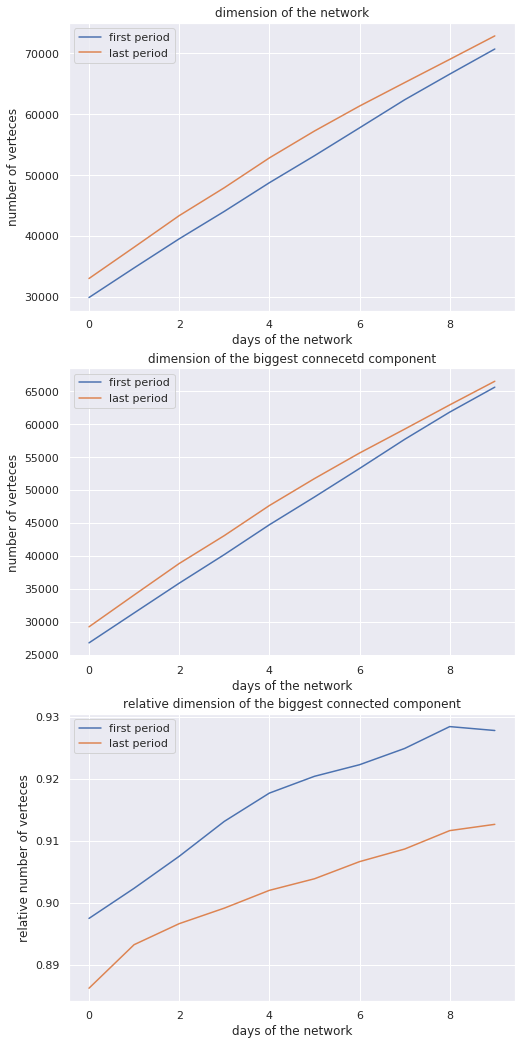

In [31]:
fig, (ax0, ax1,ax2) = plt.subplots(3,1,figsize = (8,18))
ax0.plot([g.vcount() for g in graphs['first']], label='first period')
ax0.plot([g.vcount() for g in graphs['last']],label='last period')
ax0.set_title('dimension of the network')
ax0.set_ylabel('number of verteces')
ax0.set_xlabel('days of the network')
#ax0.set_xticks(range(13))
#ax0.set_xticklabels(range(4,17))
ax0.legend()
ax1.plot(gcc['first'], label='first period')
ax1.plot(gcc['last'],label='last period')
ax1.set_title('dimension of the biggest connecetd component')
ax1.set_ylabel('number of verteces')
ax1.set_xlabel('days of the network')
#ax1.set_xticks(range(13))
#ax1.set_xticklabels(range(4,17))
ax1.legend()
ax2.plot(rel_gcc['first'],label='first period')
ax2.plot(rel_gcc['last'], label='last period')
ax2.set_title('relative dimension of the biggest connected component')
ax2.set_ylabel('relative number of verteces')
ax2.set_xlabel('days of the network')
#ax2.set_xticks(range(13))
#ax2.set_xticklabels(range(4,17))
ax2.legend()

in efetti sembra che le grandezze crescano più o meno allo stesso modo, per scrupolosità costruisco i network partendo dallo stesso numero di dati e aggiungendone la stessa quantità di volta in volta sia per il primo che per il secondo periodo

In [21]:
len(df) #numero totali di rewteet

4783720

In [22]:
len(df)//2

2391860

In [29]:
df['day_count'].iloc[2391860]  #giornata di metà dei dati

18

In [14]:
df_half1 = df.iloc[:len(df)//2] # divido tutti i dati i due metà
df_half2 = df.iloc[len(df)//2:]

In [15]:
len(df_half1) == len(df_half2)

True

In [24]:
print(len(df_half1)//15) # dati di una parte su 15 
print(len(df_half1)%15) # resto della suddivisione

159457
5


In [18]:
initial_set = (len(df_half1)//15)*5 + (len(df)//2)%15  #dati del primo --> 5 parti più il resto 
new_lines = len(df_half1)//15

In [25]:
def build_graph_iter(data,it_number): 
    global initial_set
    global new_lines
    data = data.iloc[:initial_set+it_number*new_lines]
    data = data.groupby(['retweeted_status.user.id','user.id'], as_index=False).count()
    data = data[data.weight > 1]
    return ig.Graph.TupleList(data[['retweeted_status.user.id','user.id','weight',]].itertuples(index=False), directed=True, weights=True)
    

In [20]:
graphs  = {'first' :[],'last':[]}
for it in range(10):
    graphs['first'].append(build_graph_iter(df_half1,it))

for it in range(10):
    graphs['last'].append(build_graph_iter(df_half2,it))
     
gcc = {'first' :[],'last':[]}
rel_gcc = {'first' :[],'last':[]}

for g in graphs['first']:
    cl = g.components(mode='WEAK') 
    gcc['first'].append(cl.giant().vcount())
    rel_gcc['first'].append(cl.giant().vcount()/g.vcount())
for g in graphs['last']:
    cl = g.components(mode='WEAK') 
    gcc['last'].append(cl.giant().vcount())
    rel_gcc['last'].append(cl.giant().vcount()/g.vcount())

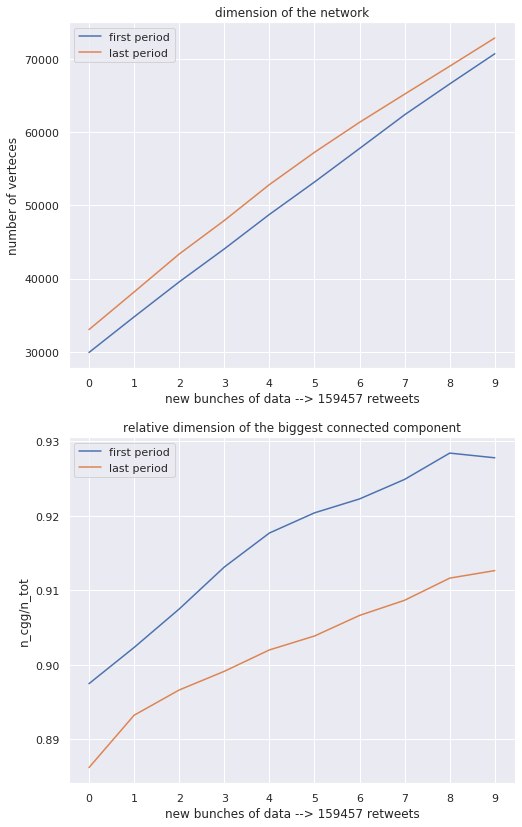

In [121]:
fig, (ax0,ax2) = plt.subplots(2,1,figsize = (8,14))
ax0.plot([g.vcount() for g in graphs['first']], label='first period')
ax0.plot([g.vcount() for g in graphs['last']],label='last period')
ax0.set_title('dimension of the network')
ax0.set_ylabel('number of verteces')
ax0.set_xlabel('new bunches of data --> %d retweets'%new_lines)
ax0.set_xticks(range(10))
ax0.legend()
#ax1.plot(gcc['first'], label='first period')
#ax1.plot(gcc['last'],label='last period')
#ax1.set_title('dimension of the biggest connecetd component')
#ax1.set_ylabel('number of verteces')
#ax1.set_xlabel('new bunches of data --> %d retweets'%new_lines)
#ax1.set_xticks(range(10))
#ax1.legend()
ax2.plot(rel_gcc['first'],label='first period')
ax2.plot(rel_gcc['last'], label='last period')
ax2.set_title('relative dimension of the biggest connected component')
ax2.set_ylabel('n_cgg/n_tot')
ax2.set_xlabel('new bunches of data --> %d retweets'%new_lines)
ax2.set_xticks(range(10))
ax2.legend()
fig.savefig('size_change_gcc(data).png')

l'andamento appare simile in entrambi i casi, e stavolta il numero di utenti della cresce abbastanza uniformemente. la differenza nell'andamento della crescità della componente connessa è di poco più di 0.01

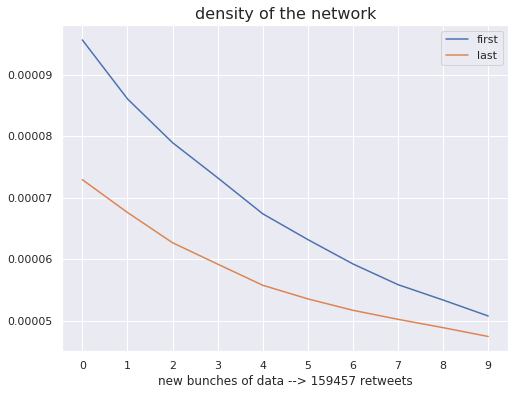

In [117]:
fig,ax = plt.subplots(1,1, figsize= (8,6))
ax.plot([g.density() for g in graphs['first']], label='first')
ax.plot([g.density() for g in graphs['last']], label = 'last')
ax.set_title('density of the network',fontsize=16)
ax.set_xlabel('new bunches of data --> %d retweets'%new_lines)
ax.set_xticks(range(10))
plt.savefig('density(data).png')
ax.legend()

anche l'andamento della densità è analogo nei due periodi, con un adiscesa un po più rapida nel primo periodo

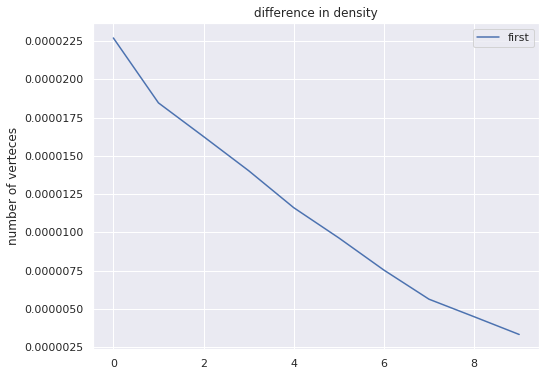

In [28]:
fig,ax = plt.subplots(1,1, figsize= (8,6))
ax.plot([g.density() - j.density() for g,j in zip(graphs['first'],graphs['last'])], label='first')
ax.set_title('difference in density')
ax.set_ylabel('number of verteces')
ax.legend()

#### Guardo se campionando 3 giorni a caso del network, risultano sempre i soliti leader

In [41]:
g_tot.vs['outdegree'] = g_tot.outdegree()

In [42]:
total_netwwork_df = pd.DataFrame({'name': g_tot.vs['name'], 'outdegree': g_tot.vs['outdegree']})

In [43]:
top_k_100 = total_netwwork_df.sort_values('outdegree')['name'].values[-100:] #100 utenti in totale più retweetati

In [44]:
def build_graph_3rand(data_retweet,days_choice=None):  #funzione per costruire netwrok con tre giorni a caso
    if days_choice.any()!=None:
        sub_set = data_retweet[data_retweet.day_count.isin(days_choice)]
    else:
        sub_set=data_retweet
    db_for_network = sub_set.groupby(['retweeted_status.user.id','user.id'], as_index=False).count()
    db_for_network = db_for_network[db_for_network.weight > 1]#.astype(int)
    return ig.Graph.TupleList(db_for_network[['retweeted_status.user.id','user.id','weight',]].itertuples(index=False), directed=True, weights=True)

In [37]:
days_count = df['day_count'].unique() #variabile con i numeri dei giorni

In [21]:
np.random.choice(days_count,10,replace=False) # prova di random.choice

array([30, 28,  8, 18, 20, 16, 17, 12,  0, 14])

In [50]:
random_graphs = [] # costruisco 20 network doi 3 giorni random
for i in range(20):
    random_graphs.append(build_graph_3rand(df,np.random.choice(days_count,3,replace=False)))

In [51]:
graphs_df = []  #costruisco i loro rispettivi dataframe con name e  degree 
for g in random_graphs:
    graphs_df.append(pd.DataFrame({'name' : g.vs['name'], 'outdegree' : g.outdegree()}))

In [52]:
#lista degli utenti più retweetati di ogni network
graphs_leader = [d.sort_values('outdegree')['name'].values[-100:] for d in graphs_df]

In [53]:
from collections import Counter

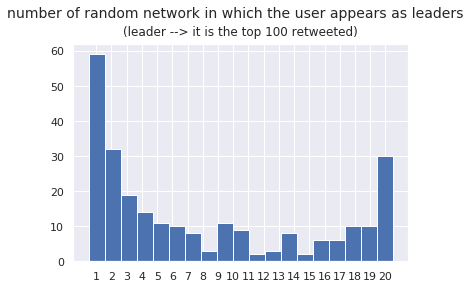

In [112]:
counter = Counter(np.concatenate(graphs_leader))
plt.hist(list(counter.values()), bins= np.linspace(0.5,20.5,20))
plt.xticks(range(1,21))
plt.suptitle('number of random network in which the user appears as leaders', fontsize = 14, y=1.01)
plt.title('(leader --> it is the top 100 retweeted)', y = 1.01)
plt.savefig('number_leaders_rand_graph.png')
plt.show()


anche da qua si vede come certi utenti siano presenti come leader in ogni network costruito (campione di 20 network costruiti sui dati di 3 giorni  a caso non consecutivi)

In [60]:
#salvo in una lista i leader che appaiono in tutti i venti 
leader_list = []
for key, value in counter.items():
    if value == 20:
        leader_list.append(key)

In [57]:
### dizionario con associazione id, username
retweeted_user_dict = {}
for values in df[['retweeted_status.user.id','retweeted_username']].values:
    retweeted_user_dict[values[0]] = values[1]

In [61]:
print('LEADERS NAME \n')  #username degli utenti che appaiono in tutti i netwrok random
for k in leader_list:
    print(retweeted_user_dict[k])

LEADERS NAME 

Filomen30847137
ilmessaggeroit
Libero_official
valy_s
LaNotiziaTweet
AmbCina
GiancarloDeRisi
sole24ore
TgLa7
poliziadistato
claudio_2022
fdragoni
LegaSalvini
ChiodiDonatella
Adnkronos
francescatotolo
NicolaPorro
ImolaOggi
fattoquotidiano
Corriere
GiorgiaMeloni
MediasetTgcom24
Cartabellotta
SkyTG24
MinisteroSalute
repubblica
ultimenotizie
RobertoBurioni
Agenzia_Ansa
RadioSavana


#### Fanno parte delle principali community?

In [62]:
g_tot.to_undirected(combine_edges='sum')
cl_tot = g_tot.community_multilevel(weights='weight', return_levels=False)  

In [63]:
clusters = cl_tot.subgraphs()   # lista con i grafi delle singole componenti
clusters_size = [cl.vcount() for cl in clusters]  #lista con il numero di utenti di ogni componente
components_df = pd.DataFrame({'cluster' : clusters, 'size' : clusters_size})

In [64]:
components_df.sort_values('size',ascending=False)['size'].head()

5    26562
6    25426
3    16960
0     9951
2     6312
Name: size, dtype: int64

la seconda maggiore componente non è molto più piccola della giant community

guardo in quli community sono i leaders

In [66]:
sorted_component_df = components_df.sort_values('size',ascending=False)['cluster'] #odinato per dimensione della community3030
for it in range(10):# guardo solo tra le prime 10 più popolose
    print('Leaders in community n:',it+1, '\n')
    for i in leader_list:
        if np.isin(i,sorted_component_df.values[it].vs['name']):
            print(retweeted_user_dict[i])
    print('------------------\n')

Leaders in community n: 1 

ilmessaggeroit
sole24ore
TgLa7
poliziadistato
Adnkronos
Corriere
MediasetTgcom24
SkyTG24
MinisteroSalute
repubblica
ultimenotizie
Agenzia_Ansa
------------------

Leaders in community n: 2 

Cartabellotta
RobertoBurioni
------------------

Leaders in community n: 3 

Filomen30847137
Libero_official
valy_s
GiancarloDeRisi
claudio_2022
fdragoni
LegaSalvini
ChiodiDonatella
francescatotolo
NicolaPorro
ImolaOggi
GiorgiaMeloni
RadioSavana
------------------

Leaders in community n: 4 

------------------

Leaders in community n: 5 

AmbCina
------------------

Leaders in community n: 6 

------------------

Leaders in community n: 7 

LaNotiziaTweet
fattoquotidiano
------------------

Leaders in community n: 8 

------------------

Leaders in community n: 9 

------------------

Leaders in community n: 10 

------------------



In [124]:
#esporto il dizionario id,username
with open('data/pickles/dict_id_name.pickle','wb') as d:
    pickle.dump(retweeted_user_dict,d)

le 3 maggiori communiy si caratterizzano nel seguente modo:
- la prima comprende notiziari
- la seconda sembra riguardare virologi e analisi della pandemia
- la terza compende leader ed esponenti della destra italiana

#### come cambiano nel tempo?

costruisco 4 network partendo dallo stesso numero di dati, che sono in successione temporale

In [10]:
print(len(df)%4)

0


In [67]:
lenght_quarter = len(df)//4 #dimensione di ogni network

In [72]:
four_graphs = [build_graph(df.iloc[lenght_quarter*i:lenght_quarter*(1+i)]) for i in range(4)]

In [73]:
as_cluster = [] # li trasoformo tutti in vertex_clustrering objects
for g in four_graphs:
    g.to_undirected(combine_edges='sum')
    as_cluster.append(g.community_multilevel(weights='weight', return_levels=False))

In [74]:
graphs_components= [] # e ora di ogni priodo divido il grafico in clusters di ccui salvo la dimensione
for cl in as_cluster:
    clusters = cl.subgraphs()
    clusters_lenght = [c.vcount() for c in clusters]
    graphs_components.append(pd.DataFrame({'cluster' : clusters, 'size' : clusters_lenght}))

In [75]:
#riordine i database dei users in ordine di dimensione
df_sorted = [graphs_components[i].sort_values('size', ascending = False) for i in range(4)] 

In [77]:
notiziari_id = [] #lista con gli id degli utenti facenti parte la community "notiziari"
for i in leader_list: 
    if np.isin(i,sorted_component_df.values[0].vs['name']): #values[0] corrisponde alla più grande community
        notiziari_id.append(i)

In [78]:
notiziari_size = [] # salvo qui le dimensione del cluster notiziari nei 4 periodi
for data in df_sorted:
    for i in range(5): #cerco la comnità notiziari tra le prime 5 di ogni periodo, suppendo ci sia
        if  len(np.intersect1d(notiziari_id, data.iloc[i,0].vs['name'], assume_unique=True)) > 5 : 
            #ipotizzo che bastino 5 utenti della lista per riconoscere la comunità
            notiziari_size.append(data.iloc[i,1])
notiziari_size

[5487, 5893, 5829, 5749]

In [79]:
#controllo per vedere se funziona l'algoritmo
for data in df_sorted:
    for i in range(5): #CONTROLLO SOLO TRA Le prime 3 comunità
        print('\n')
        print(np.intersect1d(notiziari_id, data.iloc[i,0].vs['name'], assume_unique=True)) #ipotizzo che bastino 5 della lista per riconoscdere la comunità
        



[]


[]


['150725695.0' '16476536.0' '18935802.0' '25676606.0' '331617619.0'
 '36079217.0' '395218906.0' '420351046.0' '5893702.0' '828717014.0']


[]


['1904010924.0' '20423071.0']


[]


[]


['150725695.0' '18935802.0' '25676606.0' '331617619.0' '36079217.0'
 '395218906.0' '420351046.0' '5893702.0' '828717014.0']


[]


['1904010924.0' '20423071.0']


[]


[]


['150725695.0' '18935802.0' '25676606.0' '331617619.0' '36079217.0'
 '395218906.0' '420351046.0' '5893702.0' '828717014.0']


[]


['16476536.0']


[]


[]


['150725695.0' '18935802.0' '1904010924.0' '20423071.0' '25676606.0'
 '36079217.0' '395218906.0' '420351046.0']


['16476536.0' '331617619.0' '5893702.0' '828717014.0']


[]


In [80]:
#lo stess per virolgoi
virologi_id = []
for i in leader_list:  
    if np.isin(i,sorted_component_df.values[1].vs['name']):
        virologi_id.append(i)
virologi_size = []
for data in df_sorted:
    for i in range(5):
        if  len(np.intersect1d(virologi_id, data.iloc[i,0].vs['name'], assume_unique=True)) == 2 : #==2 perchè cerco Burioni e Cartabellotta 
            virologi_size.append(data.iloc[i,1])
virologi_size

[4083, 8146, 7119, 7846]

In [82]:
destra_id = []
for i in leader_list: 
    if np.isin(i,components_df.sort_values('size',ascending=False)['cluster'].values[2].vs['name']):
        destra_id.append(i)
destra_size = []
for data in df_sorted:
    for i in range(5): 
        if  len(np.intersect1d(destra_id, data.iloc[i,0].vs['name'], assume_unique=True)) > 5 : 
            destra_size.append(data.iloc[i,1])
destra_size

[7934, 7014, 8313, 9196]

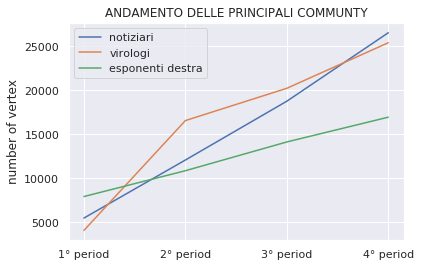

In [96]:
plt.title('ANDAMENTO DELLE PRINCIPALI COMMUNTY')
plt.plot(notiziari_size, label = 'notiziari')
plt.plot(virologi_size, label = 'virologi')
plt.plot(destra_size, label = 'esponenti destra')
plt.ylabel('number of vertex')
plt.xticks(range(4), ['%d° period'%i for i in range(1,5)])
plt.legend()
plt.savefig('community_for_each_week.png')
plt.show()

Questa analisi non considera il passato, ma dice solo nel determinato periodo quanto è stata numerosa la community.

Faccio lo stesso aggiunendo invece i periodi di volta in volta

In [90]:
four_graphs = [build_graph(df.iloc[:lenght_quarter*(1+i)]) for i in range(4)]

as_cluster = [] # li trasoformo tutti in vertex_clustrering objects
for g in four_graphs:
    g.to_undirected(combine_edges='sum')
    as_cluster.append(g.community_multilevel(weights='weight', return_levels=False))
    
graphs_components= [] # e ora di ogni priodo divido il grafico in clusters di ccui salvo la dimensione
for cl in as_cluster:
    clusters = cl.subgraphs()
    clusters_lenght = [c.vcount() for c in clusters]
    graphs_components.append(pd.DataFrame({'cluster' : clusters, 'size' : clusters_lenght}))

#riordine i database dei users in ordine di dimensione
df_sorted = [graphs_components[i].sort_values('size', ascending = False) for i in range(4)] 

In [91]:
notiziari_size = [] # salvo qui le dimensione del cluster notiziari nei 4 periodi
for data in df_sorted:
    for i in range(5): #cerco la comnità notiziari tra le prime 5 di ogni periodo, suppendo ci sia
        if  len(np.intersect1d(notiziari_id, data.iloc[i,0].vs['name'], assume_unique=True)) > 5 : 
            #ipotizzo che bastino 5 utenti della lista per riconoscere la comunità
            notiziari_size.append(data.iloc[i,1])
virologi_size = []
for data in df_sorted:
    for i in range(5):
        if  len(np.intersect1d(virologi_id, data.iloc[i,0].vs['name'], assume_unique=True)) == 2 : #==2 perchè cerco Burioni e Cartabellotta 
            virologi_size.append(data.iloc[i,1])
destra_size = []
for data in df_sorted:
    for i in range(5): 
        if  len(np.intersect1d(destra_id, data.iloc[i,0].vs['name'], assume_unique=True)) > 5 : 
            destra_size.append(data.iloc[i,1])

                                              cluster  size
0   IGRAPH UNW- 7934 47294 --\n+ attr: name (v), w...  7934
7   IGRAPH UNW- 6736 17271 --\n+ attr: name (v), w...  6736
9   IGRAPH UNW- 5487 10489 --\n+ attr: name (v), w...  5487
8   IGRAPH UNW- 4083 6248 --\n+ attr: name (v), we...  4083
13  IGRAPH UNW- 2674 3377 --\n+ attr: name (v), we...  2674
                                             cluster   size
1  IGRAPH UNW- 16574 47380 --\n+ attr: name (v), ...  16574
5  IGRAPH UNW- 12088 26318 --\n+ attr: name (v), ...  12088
2  IGRAPH UNW- 10873 80959 --\n+ attr: name (v), ...  10873
0  IGRAPH UNW- 7815 11614 --\n+ attr: name (v), w...   7815
3  IGRAPH UNW- 6735 9642 --\n+ attr: name (v), we...   6735
                                             cluster   size
6  IGRAPH UNW- 20245 68771 --\n+ attr: name (v), ...  20245
5  IGRAPH UNW- 18776 42579 --\n+ attr: name (v), ...  18776
2  IGRAPH UNW- 14143 117860 --\n+ attr: name (v),...  14143
3  IGRAPH UNW- 8567 13036 --\n+ attr: na

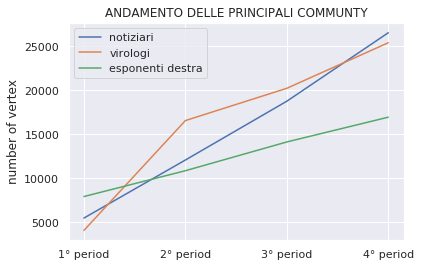

In [94]:
plt.title('ANDAMENTO DELLE PRINCIPALI COMMUNTY')
plt.plot(notiziari_size, label = 'notiziari')
plt.plot(virologi_size, label = 'virologi')
plt.plot(destra_size, label = 'esponenti destra')
plt.ylabel('number of vertex')
plt.xticks(range(4), ['%d° period'%i for i in range(1,5)])
plt.legend()
plt.savefig('coummity_change.png')
plt.show()